In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: Disparity

## a) Disparity equation

$$ \frac{x_1}{f} = \frac{p_x}{p_z}, \frac{-x_2}{f} = \frac{T - p_x}{p_z} $$

$$ d = x_1 - x_2 = \frac{f p_x}{p_z} + \frac{f(T - p_x)}{p_z} = \frac{fT}{p_z} $$

When the object is close, disparity is large, when it is far away, it is small.

## b) Plotting disparity

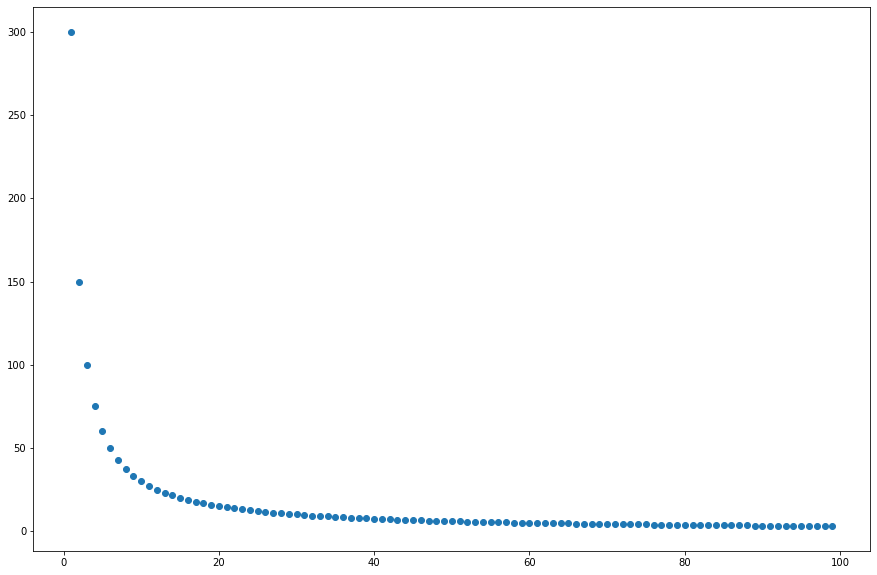

In [2]:
def disparity_example(f = 2.5, T = 120):
	pz = np.arange(1, 100)
	disp = f * T / pz
	plt.figure(figsize=(15, 10))
	plt.scatter(pz, disp)
	plt.show()

disparity_example()

## c) Specific case

$$ f = 2.5mm $$
$$ T = 120mm $$
$$ pw = 0.0074mm $$

$$ x_1 = 300 $$
$$ x_2 = 550 $$

$$ pw(x_1 - x_2) = \frac{fT}{p_z} <=> p_z = \frac{fT}{pw(x_1 - x_2)} $$

$$ p_{x_1} = \frac{2.5 * 120}{0.0074 * (550 - 300)} = 162.1mm = 0.162m $$
$$ p_{x_2} = \frac{2.5 * 120}{0.0074 * (550 - 540)} = 4054.05mm = 4.054m $$

# Exercise 2: Fundamental matrix, epipoles, epipolar lines

## Analytically

$$
x_1 = [300, 120, 1]^T \\
x_2 = [300, 170, 1]^T
$$

$$ F = \begin{bmatrix} 
0 & 0 & 0.002 \\
0 & 0 & −0.012 \\
−0.001 & 0.011 & −0.085
\end{bmatrix} \\ $$


$$ Fx_1 = [\frac{1}{500}, \frac{-3}{250}, \frac{187}{200}]^T $$
$$ Fx_2 = [\frac{1}{500}, \frac{-3}{250}, \frac{297}{200}]^T $$

## a) Function fundamental_matrix

In [3]:
from a5_utils import normalize_points, draw_epiline

In [4]:
def fundamental_matrix(points1, points2):
	pnorm1, T1 = normalize_points(points1)
	pnorm2, T2 = normalize_points(points2)
	A = []
	for p1, p2 in zip(pnorm1, pnorm2):
		A.append([p1[0] * p2[0], p1[0] * p2[1], p1[0], p1[1] * p2[0], p1[1] * p2[1], p1[1], p2[0], p2[1], 1])
	
	_, _, V = np.linalg.svd(A)
	Ft = V.T[:,-1].reshape(3,3)
	Uf, Df, Vf = np.linalg.svd(Ft)
	Df[-1] = 0
	F = (Uf * Df) @ Vf
	F = T2.T @ F.T @ T1
	return F

## b) Testing the function

In [5]:
house_points = np.array(open('data/epipolar/house_points.txt', 'r').read().split()).reshape(-1,4).astype(np.float64)
house_points_1 = house_points[:,0:2]
house_points_2 = house_points[:,2:4]
house_points_F = fundamental_matrix(house_points_1, house_points_2)
print(house_points_F)

[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


In [6]:
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY)
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY)

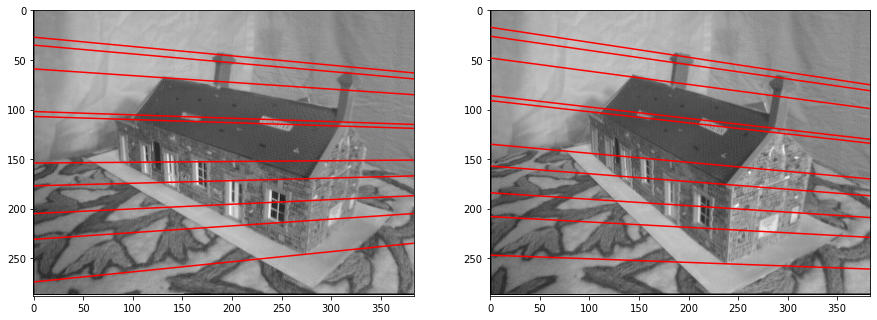

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
h, w = house1.shape
for px, py in house_points_2:
	e = np.array([px, py, 1])
	l = house_points_F.T @ e
	draw_epiline(l, h, w)

plt.subplot(1,2,2), plt.imshow(house2, cmap='gray')
h, w = house2.shape
for px, py in house_points_1:
	e = np.array([px, py, 1])
	l = house_points_F @ e
	draw_epiline(l, h, w)
plt.show()

## c) Reprojection error

In [8]:
def reprojection_error(x1, x2, F):
	px1 = np.array([x1[0], x1[1], 1])
	px2 = np.array([x2[0], x2[1], 1])
	line1 = F.T @ px2
	line2 = F @ px1
	d1 = np.abs((line1[0] * px1[0] + line1[1] * px1[1] + line1[2]) / np.sqrt(line1[0] ** 2 + line1[1] ** 2))
	d2 = np.abs((line2[0] * px2[0] + line2[1] * px2[1] + line2[2]) / np.sqrt(line2[0] ** 2 + line2[1] ** 2))

	return (d1 + d2) / 2

In [9]:
reprojection_error([85, 233], [67, 219], house_points_F)

0.14674365570474363

In [10]:
error = 0
counter = 0
for x1, x2 in zip(house_points_1, house_points_2):
	err = reprojection_error(x1, x2, house_points_F)
	error += err
	counter += 1

print(error / counter)

0.3309133698053899


## d) Ransac: get_inliers

In [11]:
def get_inliers(F, corr, threshold):
	x_pts  = corr[:,0:2]
	xi_pts = corr[:,2:4]

	points = []
	for x, xi in zip(x_pts, xi_pts):
		dist = reprojection_error(x, xi, F)
		if dist < threshold:
			points.append(np.hstack([x, xi]))
	return np.array(points)

## e) Ransac: ransac_fundamental

In [12]:
def ransac_fundamental(in_points, k, threshold):
	max_inliers = np.array([])
	max_F = 0
	for i in range(k):
		points = in_points[np.random.choice(range(len(in_points)), 8, replace=False)]
		points_1 = points[:,0:2]
		points_2 = points[:,2:4]
		F_mat = fundamental_matrix(points_1, points_2)
		inliers = get_inliers(F_mat, in_points, threshold)
		if inliers.shape[0] >= max_inliers.shape[0]:
			max_inliers = inliers
			inl1 = inliers[:,0:2]
			inl2 = inliers[:,2:4]
			max_F = fundamental_matrix(inl1, inl2)
	return max_F, max_inliers

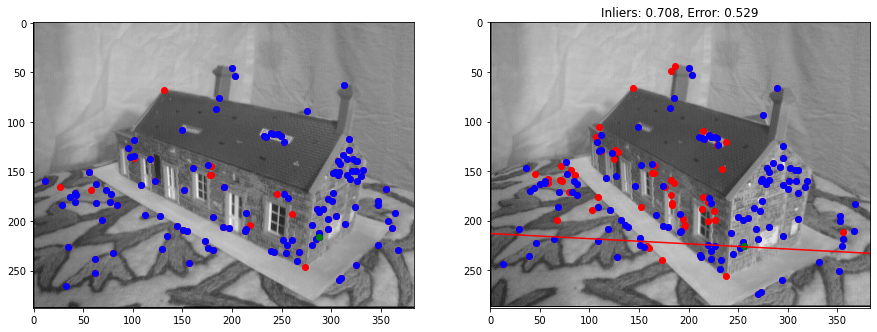

In [47]:
house_matches = np.array(open('data/epipolar/house_matches.txt', 'r').read().split()).reshape(-1,4).astype(np.float64)
house_matches_1 = house_matches[:,0:2]
house_matches_2 = house_matches[:,2:4]

ransac_F, ransac_inliers = ransac_fundamental(house_matches, 100, 2)
ransac_inl_1 = ransac_inliers[:,0:2]
ransac_inl_2 = ransac_inliers[:,2:4]
ransac_inl_rnd = ransac_inliers[np.random.randint(0, len(ransac_inliers))]

plt.figure(figsize=(15, 10))
h, w = house1.shape
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
plt.scatter(house_matches_1[:,0],house_matches_1[:,1], c='red')
plt.scatter(ransac_inl_1[:,0], ransac_inl_1[:,1], c='blue')
plt.scatter(ransac_inl_rnd[0], ransac_inl_rnd[1], c='green')

ransac_proc_inliers = np.round(len(ransac_inl_2) / len(house_matches_2), 3)
ransac_error = np.round(reprojection_error(ransac_inl_rnd[0:2],ransac_inl_rnd[2:4], ransac_F), 3)
h, w = house2.shape
plt.subplot(1,2,2), plt.imshow(house2, cmap='gray'), plt.title(f"Inliers: {ransac_proc_inliers}, Error: {ransac_error}")
plt.scatter(house_matches_2[:,0],house_matches_2[:,1], c='red')
plt.scatter(ransac_inl_2[:,0], ransac_inl_2[:,1], c='blue')
plt.scatter(ransac_inl_rnd[2], ransac_inl_rnd[3], c='green')
e = np.array([ransac_inl_rnd[0], ransac_inl_rnd[1], 1])
draw_epiline(house_points_F @ e, h, w)

plt.show()

## f) Ransac: Automatic fundamental matrix estimation

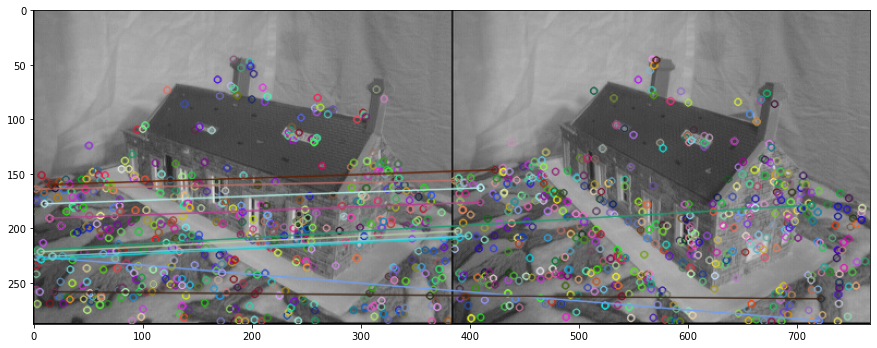

(<matplotlib.image.AxesImage at 0x1f68b230160>, None)

In [42]:
sift = cv2.SIFT_create()
house_key1, house_desc1 = sift.detectAndCompute(house1, None)
house_key2, house_desc2 = sift.detectAndCompute(house2, None)

bf = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=True)
house_matches = bf.match(house_desc1.astype(np.uint8), house_desc2.astype(np.uint8))
# house_matches = sorted(house_matches, key = lambda x:x.distance)
house_match = np.zeros((len(house_matches),4))
for i in range(len(house_matches)):
	match = house_matches[i]
	p1 = house_key1[match.queryIdx].pt
	p2 = house_key2[match.trainIdx].pt
	house_match[i,:] = np.hstack([np.asarray(p1), np.asarray(p2)])
house_auto_F, house_auto_inliers = ransac_fundamental(house_match, 100, 1)
house_a_match_1 = house_match[:,0:2]
house_a_match_2 = house_match[:,2:4]

img3 = 0
img3 = cv2.drawMatches(house1,house_key1,house2,house_key2,house_matches[:10], img3)
plt.figure(figsize=(15,10))
plt.imshow(img3),plt.show()

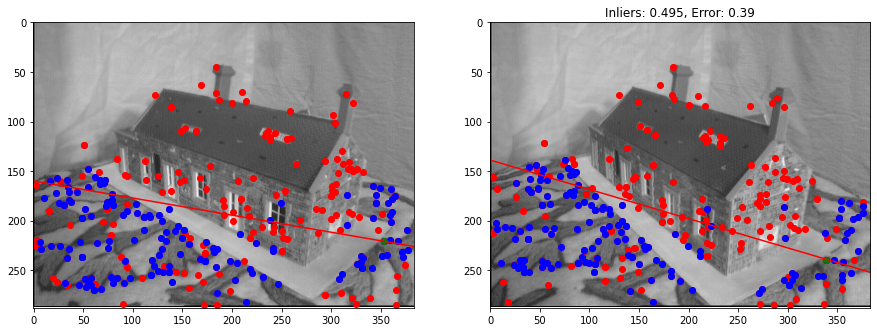

In [50]:
house_ainl_1 = house_auto_inliers[:,0:2]
house_ainl_2 = house_auto_inliers[:,2:4]
house_ainl_rnd = house_auto_inliers[np.random.randint(0, len(house_auto_inliers))]

# first image
plt.figure(figsize=(15, 10))
h, w = house1.shape
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
plt.scatter(house_a_match_1[:,0],house_a_match_1[:,1], c='red')
plt.scatter(house_ainl_1[:,0], house_ainl_1[:,1], c='blue')
plt.scatter(house_ainl_rnd[0], house_ainl_rnd[1], c='green')
e = np.array([house_ainl_rnd[2], house_ainl_rnd[3], 1])
draw_epiline(house_auto_F.T @ e, h, w)

# second image
housea_proc_inliers = np.round(len(house_ainl_2) / len(house_a_match_2), 3)
housea_error = np.round(reprojection_error(house_ainl_rnd[0:2],house_ainl_rnd[2:4], house_auto_F), 3)
h, w = house2.shape
plt.subplot(1,2,2), plt.imshow(house2, cmap='gray'), plt.title(f"Inliers: {housea_proc_inliers}, Error: {housea_error}")
plt.scatter(house_a_match_2[:,0],house_a_match_2[:,1], c='red')
plt.scatter(house_ainl_2[:,0], house_ainl_2[:,1], c='blue')
plt.scatter(house_ainl_rnd[2], house_ainl_rnd[3], c='green')
e = np.array([house_ainl_rnd[0], house_ainl_rnd[1], 1])
draw_epiline(house_auto_F @ e, h, w)

# Exercise 3: Triangulation

## a) Function triangulate

In [ ]:
def triangulate(corr, P1, P2):
	